## 주제분석 2주차 패키지 과제
### ★주혜인★

In [1]:
import pandas as pd 
import numpy as np

### 1. 데이터분할
#### 1.1 데이터 불러오기

In [2]:
train=pd.read_csv("train.csv")

#### 1.2 x,y 분리

In [3]:
train_y=train["price"]
train_x=train.drop(columns=['price'])

#### 1.3 validation set 분할 - 첫번째
    - 사이킷런의 train_test_split을 통해 train데이터를 8:2로 validation set을 만들어주세요.
    - 즉 train중에서 train/val이 있고, test set이 따로 존재합니다.
    - test set은 전처리 과정에서 절대 사용되지 않을 예정입니다

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
x_tr,x_te,y_tr,y_te=train_test_split(train_x,train_y, test_size=0.2, train_size=0.8)

#### 1.4 질문 - 이렇게 데이터를 나눌 경우 어떤 문제가 발생할 수 있을까요?
    우리의 최종적인 목표는 아파트 실거래가를 "예측"하는 것입니다. 
    즉, 과거의 정보를 이용하여 미래의 정보를 얻어내야 합니다. 
    validation set의 목적은 bias가 적은 모델을 만들기 위해 train set을 이용하여 만든 모델을 평가, 즉 test error를 추정하기 위한 것입니다. 
    그러나 위와 같은 방식으로 train set과 validation set을 나누면 train set에 과거 뿐만 아니라 예측하려는 시점의 정보도 포함되어있는 것과 같게되어 test error rate를 올바르게 추정할 수 없습니다. 

#### 1.5 validation set 분할 - 두 번째
    transaction_year == 4인 행을 validation으로 지정해서 분할하세요.

In [6]:
val=train[train.transaction_year==4]
tr=train[train.transaction_year!=4]
val_x=val.drop(columns=['price'])
val_y=val['price']
tr_x=tr.drop(columns=['price'])
tr_y=tr['price']

#### 1.6 캣부스트 인코딩

In [7]:
#! pip install category_encoders

In [8]:
from category_encoders.cat_boost import CatBoostEncoder

In [9]:
cbe_encoder=CatBoostEncoder()
cbe_encoder.fit(tr_x,tr_y)
tr_cbe=cbe_encoder.fit_transform(tr_x,tr_y)
val_cbe=cbe_encoder.transform(val_x)
val_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


### 2. 릿지회귀

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns 

#### 2.1 상관계수 플랏
    캣부스트 인코딩을 시행한 튜닝을 위한 trainset에 대해 상관계수플랏을 그리세요.
    해석해주세요. 릿지 회귀가 잘 작동할까요?
     
     -> 대답:아니요
     릿지 회귀가 필요한 상황은 다중공선성 문제가 있을 때 입니다. 그러나 아래의 상관계수 플랏을 보면, 변수들간 상관계수가 대부분 낮음을 알 수 있습니다. dong과 dpt는 비교적 상관관계가 높은데, 비교적 가격이 비싼 지역일수록 좋은 아파트가 많아서 일까요? 이런저런 생각이 들지만 다른 변수들은 다중공선성문제에서 자유로워 보입니다.

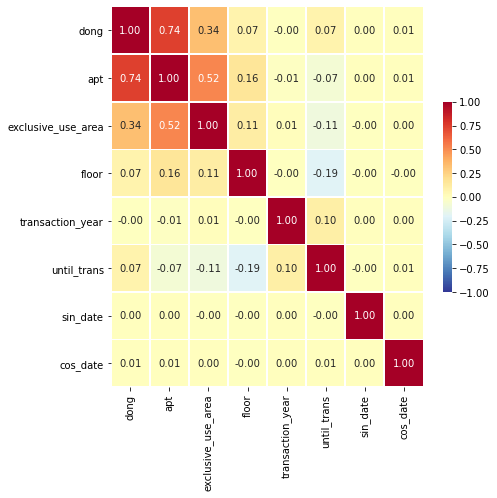

In [11]:
fig, ax = plt.subplots( figsize=(7,7) )
sns.heatmap(data = tr_cbe.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r',cbar_kws={"shrink": .5},
vmin = -1,vmax = 1)
plt.show()

#### 2.2 해석과 무관하게 일단 릿지 튜닝
    mse를 비교해서 튜닝을 진행하세요.
    릿지의 튜닝파라미터 알파는 0.00001, 0.0001, 0.001, 0.01, 0.1로 설정합니다.
    알파가 클수록 강한 페널티입니다.
    튜닝결과를 시각화해주세요.

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
alphas=[ 0.00001, 0.0001, 0.001, 0.01, 0.1]
mse = [0,0,0,0,0]
for i in range(5):
    alpha=alphas[i]
    ridge = Ridge(alpha, normalize=True)
    ridge.fit(tr_cbe,tr_y)
    pred = ridge.predict(val_cbe)
    mse[i] = sqrt(mean_squared_error(pred, val_y))

In [14]:
mse

[14777.918315870882,
 14778.250472080974,
 14781.580780645929,
 14815.7162394476,
 15213.29409933219]

#### 2.3 튜닝결과 시각화

In [15]:
mse.index(min(mse))

0

Text(0, 14800, 'smallest mse')

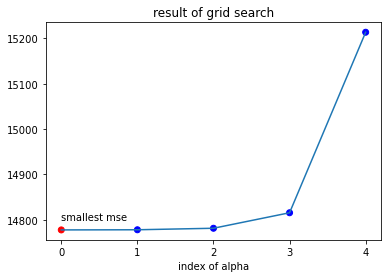

In [16]:
plt.scatter(range(0,5), mse,c=['red','blue','blue','blue','blue']) #시각화 꼭 해라~
plt.plot(range(0,5), mse)
plt.title("result of grid search")
plt.xlabel("index of alpha")
plt.xticks(range(0,5))
plt.text(0,14800, "smallest mse")

#### 2.4 해석

    alpha가 가장 작은 값인 0.00001일 때 mse가 가장 낮습니다. 왜 일까요? 
    다중공선성이 존재하는 경우에는 베타의 분산이 매우 커집니다. bias-variance trade-off를 이용하여 bias는 조금 늘리는 대신 variance를 줄여주는 방법 중 하나가 방금한 ridge regression입니다. alpha는 penalty term으로 베타를 추정할 때 특정 범위 안에 존재할 수 있도록 조절해주는 역할을 합니다. alpha가 0에 가까울수록 LSE를 추정하는 것과 비슷해집니다. 
    위의 correlation plot에서 알 수 있었듯이, 이 데이터는 독립변수간의 상관관계가 거의 없음을 알 수 있습니다. 따라서, 축소추정이 필요하지 않은 상황이라고도 할 수 있기 때문에 alpha값이 가장 작을 때 mse가 가장 작게 나온 것 같다는 생각이듭니다.

#### 2.5 그냥 선형 모양으로! ----어떤 게 나을지 꼭 써라~~~~
그냥 linear regression을 튜닝을 위한 trainset에 적합시키고, validation set에 대한 rmse를 계산하세요.
linear regression은 다른 튜닝 파라미터를 필요로하지 않습니다.
ridge와의 validation rmse를 비교했을 때, 어떤 모형을 쓰는 것이 나을지 말해주세요.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(tr_cbe, tr_y)
pred= lin_reg.predict(val_cbe)
reg_mse=sqrt(mean_squared_error(pred, val_y))
reg_mse<min(mse)

True

위의 결과를 통해서 알 수 있듯이 ridge regression의 mse 중 최솟값보다 선형회귀를 통해 얻은 mse값이 더 작습니다. 따라서 굳이 bias를 만들면서 ridge regression을 쓰기 보다는 이 데이터에는 linear regression모형이 더 적절하다고 판단됩니다.

### 3. Light GBM

In [19]:
#! pip install lightgbm

#### 3.1 ligthgbm 이해


모형에 대해 아주 기본적인 이해는 필요하겠죠? LGBM의 특징/장점/문제점을 적어주세요.

20-01 데마팀 클린업 3주차 혹은 또 다른 데마팀 클린업을 보셔도 괜찮습니다.
구글링해도 잘 나옵니다.

lgbm은 기본적으로 부스팅 모델입니다. 부스팅 알고리즘은 틀린 부분에 가중치를 더하면서 진행하는 알고리즘이고 그 중 gradient boosting은 그 가중차를 경사하강법으로 진행하는 것입니다. 그 중 light gbm은 대용량 데이터 처리가 가능하고, 다른 모델보다 더 적은 자원을 사용하며 빠른 속도를 자랑합니다.(그러나 너무 적은 데이터를 이용하면 과적합의 위험 존재) lgbm은 leaf wise 트리 분할, 트리의 균형을 맞추기 보단 리프 노드를 지속적으로 분할하면서 진행하기 때문에 level wise 분할을 사용하는 모델보다 연산량이 적습니다. learning rate를 줄이면서 n_estimator를 크게 하는 것이 부스팅에서의 기본적인 튜닝 방안입니다. parmeter중 몇가지에 대해서만 알아봤습니다. num_leaves를 늘리면 정확도는 높아지지만 트리가 점점 깊어지고 과적합될 수 있습니다. min_child_sample를 크게 설정하여 트리가 깊어지는 것을 방지할 수 있으며 amx_depth는 깊이를 제한해주어 위의 두 파라미터와 함께 과적합을 개선하는데 사용됩니다.

#### 3.2 LGBM 튜닝
    LGBM의 튜닝파라미터는 많습니다.
    max_depth, learning_rate, lambda, min_child_samples 등 다양한데, 패키지에서는 learning rate만 튜닝하도록 하겠습니다.
    [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99] 이렇게 튜닝해주세요.
    부스팅에서는 일단 learning rate과 iteration의 trade off를 적절하게 고려해줘서 학습속도를 맞춰준다음, 세부적인 튜닝을 하는게 일반적입니다.
    더하고 싶으면 해서 더 좋은 성능을 내셔도 됩니다! 보통 enumerate를 통해 파라미터를 묶어줘서 진행합니다.

In [20]:
rates=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]

In [21]:
from sklearn.model_selection import KFold,GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [22]:
mse = [0,0,0,0,0,0,0]
for i in range(7):
    rate=rates[i]
    lgbm =LGBMRegressor(learning_rate=rate)
    lgbm.fit(tr_cbe,tr_y)
    pred = lgbm.predict(val_cbe)
    mse[i] = sqrt(mean_squared_error(pred, val_y))

In [23]:
mse

[20425.56868365825,
 12022.076838668658,
 11590.66141311688,
 11203.645981790534,
 11529.176861780024,
 13135.209268880475,
 12646.056552072083]

In [24]:
mse.index(min(mse))

3

#### 3.3 튜닝결과 시각화
    learning_rate의 변화에 따른 remse의 변화를 시각화해주세요!

Text(2, 12000, 'smallest mse with alpha =11203.65 ')

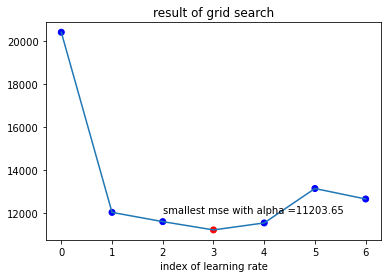

In [25]:
plt.scatter(range(0,7), mse , c=['blue','blue','blue','red','blue','blue','blue']) #시각화 꼭 해라~
plt.plot(range(0,7), mse)
plt.title("result of grid search")
plt.xlabel("index of learning rate")
plt.xticks(range(0,7))
plt.text(2,12000, "smallest mse with alpha =11203.65 ")


#### 3.4 튜닝에 대하여 알아보자
    우리가 한 튜닝방식은 그리드 서치(Grid Search)방법입니다. 다른 방법으로는 Random Search와 Bayesian Optimization 방법이 있습니다.
    세 가지 방법에 대해서 간단히 설명하고, 장단점을 말해주세요.
    요즘에는 Neural Process 기반의 Optimization이란 방법도 활발히 연구중이라던데...그냥 그렇다구요 ㅎㅎㅎ 원래 Bayesian Optimization이 Gaussian Process 기반인데, 이걸 뛰어넘는 성능이래요 암튼~


    먼저 우리가 실행한 방식인 Grid Search는 사전에 지정한 여러개의 잠재적 parameter들의 후보군들의 조합 중에서 가장 최적의 조합을 찾아줍니다. 오늘은 최적의 조합을 mse를 기준으로 찾았습니다. 즉, grid search는 모둔 경우의 수의 조합을 이용하여 가장 우수한 성능을 보이는 parameter의 조합을 찾는 과정입니다. 이러한 방법은 하나하나 해보기 때문에 parameter의 수가 늘어날 수록 시간이 아주 오래 걸린다는 단점이 있습니다.
    Random search는 파라미터 값을 랜덤하게 선택한 후 그 중 우수한 성능을 보인 파라미터를 이용하여 모델을 생성하는 방식입니다. 이는 그리드서치에 비해서 불필요한 탐색 횟수를 줄여준다는 점이 특징입니다. 랜덤하게 숫자를 넣은 뒤, 정해진 간격 사이에 위치한 값들에 대해서도 확률적으로 탐색이 가능하므로, 최적 hyperparameter값을 더 빨리 찾을 수 있습니다.
    Bayesian Optimization은 기존의 결과들을 이용하여 parameter를 설정하는 방법입니다. surrogate model과 acquisition function으로 나뉩니다. surrogate model은 지금까지 추론한 결과들을 바탕으로 주로 gaussian process를 이용하여 f(x)의 대략적인 값을 추정하는 방식입니다. aqusition function은 surrogate model의 확률분포를 이용해서 나온 값들보다 더 큰 값이 나올 가능성이 제일 높은 점을 알려주는 함수입니다. 가장 큰 점을 찾기 위해 exploration(불확실성이 가장 높은 곳에서 지금까지 나온 값들 보다 더 좋은 값이 있을 것이다)전략과 expextation(지금까지 나온 것들 중에서 높은 값들 근처에서 더 좋은 것이 있을 것이다)전략을 사용합니다.이 둘이 적절한 균형을 이루도록 aqusition function을 만들고 이를 expected improvement함수라고 합니다.

### 4. test set

#### 4.1 test set 불러오기
    test set을 불러오고
    X와 y를 분리하세요

In [26]:
test=pd.read_csv("test.csv")
te_x=test.drop(columns=['price'])
te_y=test["price"]

#### 4.2 캣부스트 인코딩    
    전체 train set에 대해 캣부스트 인코딩을 시행해주세요.
    인자에는 train_x/train_y/test_x가 들어갈겁니다.

In [27]:
cbe_encoder=CatBoostEncoder()
cbe_encoder.fit(tr_x,tr_y)
tr_cbe=cbe_encoder.fit_transform(tr_x,tr_y)
te_cbe=cbe_encoder.transform(te_x)
te_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,89176.597368,86280.203194,70.80,1,5,10,-1.000000e+00,-1.836970e-16
1,89176.597368,86280.203194,94.51,8,5,10,-2.449294e-16,1.000000e+00
2,89176.597368,86280.203194,160.85,11,5,10,-2.449294e-16,1.000000e+00
3,89176.597368,86280.203194,94.51,6,5,10,1.000000e+00,3.061617e-16
4,89176.597368,86280.203194,136.40,3,5,10,1.000000e+00,3.061617e-16


#### 4.3 최적의 파라미터 적합
    2와 3의 결과에서 최적의 파라미터(모델)을 전체 trainset에 대해 적합하세요.

In [28]:
#Regression
reg = LinearRegression()
reg.fit(tr_cbe, tr_y)
pred= lin_reg.predict(te_cbe)
reg_mse=sqrt(mean_squared_error(pred, te_y));print(reg_mse)

19866.89294820843


In [29]:
#LGBM
rate=rates[3]
lgbm =LGBMRegressor(learning_rate=rate)
lgbm.fit(tr_cbe,tr_y)
pred = lgbm.predict(te_cbe)
mse= sqrt(mean_squared_error(pred, te_y)) ; print(mse)

17705.780985779136


#### 4.4 test set에 대해 평가
    두 모델을 test set에 대해 평가해서 비교하세요

In [30]:
reg_mse>mse

True

mse값을 통해 비교하였을 때, lgbm이 더 우수한 성능을 보였습니다. learning rate이외에도 다른 파라미터를 튜닝하여 더 우수한 성능을 낼 수 있을 것으로 기대됩니다!